## MoneyPuck: Analyzing NHL Player Performance

#### Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

#### Import Data

In [2]:
file = "data/game_skater_stats.csv"
raw_df = pd.read_csv(file)
raw_df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,2011030221,8467412,1,999,0,0,1,3,0,0,...,0,0,0,0,0,0,-1,885,98,16
1,2011030221,8468501,1,1168,0,0,0,4,0,0,...,0,1,1,0,0,1,0,767,401,0
2,2011030221,8470609,1,558,0,0,2,1,0,0,...,2,0,0,0,0,1,-1,542,0,16
3,2011030221,8471816,1,1134,0,0,1,4,0,0,...,0,1,0,0,0,1,-1,935,183,16
4,2011030221,8472410,1,436,0,0,1,3,0,0,...,6,0,0,0,0,0,-1,436,0,0


### Data Cleaning

In [3]:
raw_df.count()

game_id                 411578
player_id               411578
team_id                 411578
timeOnIce               411578
assists                 411578
goals                   411578
shots                   411578
hits                    411578
powerPlayGoals          411578
powerPlayAssists        411578
penaltyMinutes          411578
faceOffWins             411578
faceoffTaken            411578
takeaways               411578
giveaways               411578
shortHandedGoals        411578
shortHandedAssists      411578
blocked                 411578
plusMinus               411578
evenTimeOnIce           411578
shortHandedTimeOnIce    411578
powerPlayTimeOnIce      411578
dtype: int64

In [4]:
drop_na_df = raw_df.dropna(how='any')
drop_na_df.count()

game_id                 411578
player_id               411578
team_id                 411578
timeOnIce               411578
assists                 411578
goals                   411578
shots                   411578
hits                    411578
powerPlayGoals          411578
powerPlayAssists        411578
penaltyMinutes          411578
faceOffWins             411578
faceoffTaken            411578
takeaways               411578
giveaways               411578
shortHandedGoals        411578
shortHandedAssists      411578
blocked                 411578
plusMinus               411578
evenTimeOnIce           411578
shortHandedTimeOnIce    411578
powerPlayTimeOnIce      411578
dtype: int64

In [5]:
drop_na_df.columns

Index(['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals',
       'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce'],
      dtype='object')

In [6]:
full_data_df = drop_na_df.rename(columns={
    'game_id':'Game ID',
    'player_id':'Player ID',
    'team_id': 'Team ID',
    'timeOnIce':'Time On Ice',
    'assists':'Assists',
    'goals':'Goals',
    'shots':'Shots',
    'hits':'Hits',
    'powerPlayGoals':'Power Play Goals',
    'powerPlayAssists':'Power Play Assists',
    'penaltyMinutes':'Penalty Minutes',
    'faceOffWins':'Faceoff Wins',
    'faceoffTaken':'Faceoff Taken',
    'takeaways':'Takeaways',
    'giveaways':'Giveaways',
    'shortHandedGoals':'Short Handed Goals',
    'shortHandedAssists':'Short Handed Assists',
    'blocked':'Blocked',
    'plusMinus':'Plus Minus',
    'evenTimeOnIce':'Even Time on Ice',
    'shortHandedTimeOnIce':'Short Handed Time on Ice',
    'powerPlayTimeOnIce':'Power Play Time on Ice'
})
full_data_df.head()

,Game ID,Player ID,Team ID,Time On Ice,Assists,Goals,Shots,Hits,Power Play Goals,Power Play Assists,...,Faceoff Taken,Takeaways,Giveaways,Short Handed Goals,Short Handed Assists,Blocked,Plus Minus,Even Time on Ice,Short Handed Time on Ice,Power Play Time on Ice
0,2011030221,8467412,1,999,0,0,1,3,0,0,...,0,0,0,0,0,0,-1,885,98,16
1,2011030221,8468501,1,1168,0,0,0,4,0,0,...,0,1,1,0,0,1,0,767,401,0
2,2011030221,8470609,1,558,0,0,2,1,0,0,...,2,0,0,0,0,1,-1,542,0,16
3,2011030221,8471816,1,1134,0,0,1,4,0,0,...,0,1,0,0,0,1,-1,935,183,16
4,2011030221,8472410,1,436,0,0,1,3,0,0,...,6,0,0,0,0,0,-1,436,0,0


**Proposal:** Analyze NHL player statistics from the 2011/2012 season through the 2018/2019 season to determine whether or not a player with have a high scoring game, a single goal game, or no goals.

Considering the objective of this analysis, we are trying to determine which player statistics are best in determining how many goals a player will score in a game. As a point of reference, below is the average number of goals scored by a player in a given game between 2011 and 2019.

In [65]:
avg_goals_scored = full_data_df['Goals'].mean()
print(f'Average number of goals scored by a player over the course of 8 seasons:{round(avg_goals_scored,2)}')

Average number of goals scored by a player over the course of 8 seasons:0.15


In [98]:
full_data_df[['Goals','Time On Ice','Assists','Shots','Hits','Takeaways','Blocked']].mean()

Goals            0.150846
Time On Ice    993.614911
Assists          0.258571
Shots            1.688545
Hits             1.311576
Takeaways        0.384335
Blocked          0.801833
dtype: float64

#### Restructure the Goals columns to contain three values: 0, 1, and 2
    - 0 = No goals scored
    - 1 = One goal scored
    - 2 = Multiple goals scored

In [7]:
goals = full_data_df[['Goals']].values
goals[goals > 1] = 2
full_data_df['Goals'] = goals

# Random Forest Classifier

##### Use a Random Forest Classifier to identify the most important variables

In [24]:
rfc_df = full_data_df[['Goals','Time On Ice','Assists','Shots','Hits','Takeaways','Blocked']]
X = rfc_df.drop('Goals', axis=1)
y = rfc_df[['Goals']]

In [25]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##### Scoring our RFC determines the reliability of the model

In [26]:
rf.score(X, y)

0.9311309156466089

In [41]:
importances = rf.feature_importances_
sorted(zip(importances, X.columns), reverse=True)

[(0.7588371606498667, 'Time On Ice'),
 (0.14473794670987536, 'Shots'),
 (0.040858406364983675, 'Hits'),
 (0.02124942895125934, 'Blocked'),
 (0.01752483702465744, 'Assists'),
 (0.01679222029935737, 'Takeaways')]

##### Gathered from our RFC, the most influential variables on our dependent variable (Goals) are as follows:
    - Time on Ice
    - Shots
    - Hits
    - Blocked
Although *Assists* and *Takeaways* are the least influential, we will continue to included them in our anaylsis for a holistic approach towards player analysis.

# Regressions and Models

Using **k-Nearest-Neighbor**, **Linear Regressions**, and **ANOTHER** we will determine what player statistics are most indicutive in determining whether a player with have a multi-goal game, score once, or not score at all.

In [149]:
# X = knn_df.drop(columns='Goals')
# y = knn_df['Goals'].values

## K-Nearest-Neighbor

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

Once we have the initial model built, we can test it against our test data

In [43]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
knn.predict(X_test)[0:5]

array([0, 0, 0, 1, 0])

In [153]:
knn.score(X_test, y_test)

0.8335682005928373

Our initial model performs fairly well with an **83.4%** accuracy. However, we can refine our model to perform even better

##### k-Fold Cross-Validation #
Using k-Fold Cross-Validation, we can split our data into 5 groups, and the model would be trained and tested 5 separate times so each group would get a chance to be the test set.

In [44]:
knn_cv = KNeighborsClassifier(n_neighbors=3)
cv_scores = cross_val_score(knn_cv, X, y, cv=5)
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.83539245 0.83402984 0.83270567 0.83327462 0.83398936]
cv_scores mean:0.8338783853950268


Using cross-validation increased our accuracy by less than a percent, however Hypertuning our model parameters can improve its accuracy.

In [46]:
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [47]:
knn_gscv.best_params_

{'n_neighbors': 24}

In [48]:
knn_gscv.best_score_

0.8621913707729763

By hypertuning our model using 24 params instead of 3, we were able to increase our models accuracy by 2.82% to **86.22%**

In [95]:
knn_gscv.predict(X_test)[650:700],

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),)

**Test model against player statline**

In [115]:
test_stat = pd.DataFrame(np.array([[1336, 2, 9, 6, 1, 2]]),
                   columns=['Time On Ice','Assists','Shots','Hits','Takeaways','Blocked'])

In [116]:
knn_gscv.predict(test_stat)

array([1])

## Linear Regression

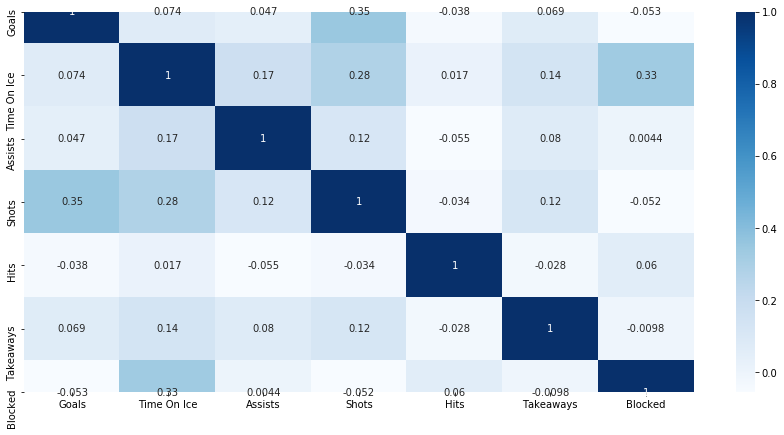

In [117]:
lin_data = full_data_df[['Goals','Time On Ice','Assists','Shots','Hits','Takeaways','Blocked']]
cor = lin_data.corr()
plt.figure(figsize=(15,7))
cor = lin_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

#### Determine the correlation between Goals (Dependent Variable) and all other variables (Independent)

In [118]:
cor_target = abs(cor["Goals"])
relevant_features = cor_target[cor_target>0.0]
relevant_features

Goals          1.000000
Time On Ice    0.074278
Assists        0.047200
Shots          0.352045
Hits           0.037712
Takeaways      0.069346
Blocked        0.053216
Name: Goals, dtype: float64

The variables with the strongest correlation to Goals are *Shots*, *Time On Ice*, and *Takeaways*. Before conducting further analysis, we need to check if any of our varaibles have a strong correlation to one another.

In [123]:
print(lin_data[['Shots','Time On Ice']].corr())

                Shots  Time On Ice
Shots        1.000000     0.281414
Time On Ice  0.281414     1.000000


In [124]:
print(lin_data[['Time On Ice', 'Takeaways']].corr())

             Time On Ice  Takeaways
Time On Ice     1.000000   0.137132
Takeaways       0.137132   1.000000


In [125]:
print(lin_data[["Takeaways","Shots"]].corr())

           Takeaways     Shots
Takeaways   1.000000  0.121022
Shots       0.121022  1.000000


Out of all the tested variables *Shots* and *Time On Ice* showed the highest correlation, have the correlation is not strong enough to eliminate either of the variables. Because *Shots* showed the highest correlation to *Goals*, we will build a Linear Regression Model using *Goals* and *Shots*. 

Shape:  (411578, 1) (411578, 1)


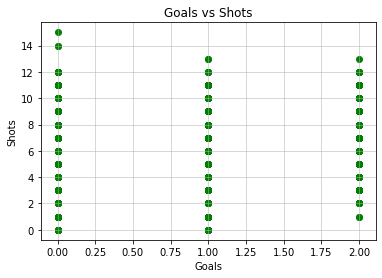

In [137]:
X = lin_data["Goals"].values.reshape(-1, 1)
y = lin_data["Shots"].values.reshape(-1, 1)

print("Shape: ", X.shape, y.shape)
plt.title("Goals vs Shots")
plt.xlabel('Goals')
plt.ylabel('Shots')
plt.grid(linewidth=.5)
plt.scatter(X, y, color='green')

##### Build the Model

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.12421253857675062
Testing Score: 0.12282779758886318


In [146]:
predicted = model.predict(X_test)

mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 2.085584012930161
R-squared (R2 ): 0.1228277975888632


Considering a strong MSE score will be close to zero and strong R2 Score will be close to 1, we can see the Linear Regression does not provide the same confidence or accuracy as the kNN model

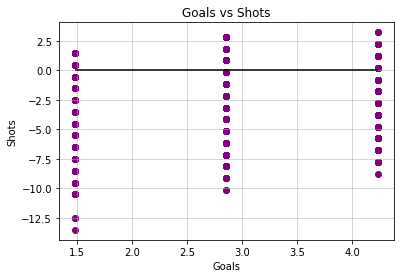

In [151]:
predictions = model.predict(X)
plt.scatter(predictions, predictions - y, color='purple')
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.title("Goals vs Shots")
plt.xlabel('Goals')
plt.ylabel('Shots')
plt.grid(linewidth=.5)
plt.show()

Based on the graph above, a linear regressional model does not provide the best predictive modeling for the purposes of our proposal.

## Nueral Network

In [206]:
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [207]:
from tensorflow.keras.models import Sequential
model = Sequential()

In [208]:
from tensorflow.keras.layers import Dense
number_inputs = 6
number_hidden_nodes = 4
model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))

In [209]:
number_classes = 2
model.add(Dense(units=number_classes, activation='softmax'))

In [210]:
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [211]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [212]:
from tensorflow.keras.utils import to_categorical 
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [213]:
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=1000,
    shuffle=True,
    verbose=2
)

ValueError: A target array with shape (329262, 3) was passed for an output of shape (None, 2) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.